# Matrix Approximation

In [2]:
import torch
import torch.nn as nn
from torch import optim
#from torchdiffeq import odeint_adjoint as odeint
from scipy.linalg import expm
from torchdiffeq import odeint
import numpy as np
import csv
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

### Defining essential functions

In [3]:
def dydt(y, t, A):
    return torch.mm(y,A)

In [4]:
def phi_A(y,A):
    return odeint(lambda t,x : dydt(x,t,A), y, torch.tensor([0., 1.]))[1]

### Neural ODE structure

In [5]:
class ODEFunc(torch.nn.Module):
    def __init__(self, A):
        super(ODEFunc, self).__init__()
        self.A = torch.nn.Parameter(torch.tensor(A))
        
    def forward(self, t, y):
        return dydt(y, t, self.A)

In [6]:
class NeuralODE(torch.nn.Module):
    def __init__(self, A_init):
        super(NeuralODE, self).__init__()
        self.func = ODEFunc(A_init)
        self.dim=len(A_init)
        self.hidden_layer = torch.nn.Linear(self.dim, 100)
        self.output_layer = torch.nn.Linear(100, self.dim*self.dim)
        
    def forward(self, y):
        y = self.hidden_layer(y)
        y = torch.relu(y)
        y = self.output_layer(y)
        return y
    
    def get_A(self):
        return self.func.A

## Training

In [10]:
def train_model(model, x_data,y_data,epochs=300, lr=0.05):
    training_loss=[]
    y_pred_list = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = odeint(model.func, x_data, torch.tensor([0., 1.]), method='dopri5')[1]
        loss = criterion(y_pred, y_data)
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            #print(f"Epoch {epoch}, Training Loss: {loss:.4f}")
            predict=torch.diag(neural_ode.get_A())
            #print(predict)
            training_loss.append(round(loss.detach().numpy().item(),3))
            y_pred_list.append(predict.detach().numpy())
    return training_loss,y_pred_list

### Parameters

In [28]:
dim = 10 #dimension of the matrix
mean = 1 #mean of the diagonal values
n_samples=100 #number of samples
stddevs=[i/10 for i in range(1,11)] #standard deviations from 0.1 to 1

In [9]:
#gaussian distribution for the x_i

x_data = torch.randn(n_samples, dim)

In [12]:
import numpy as np

data = {}

file_path = 'data.npy'
if os.path.exists(file_path):
    data = np.load(file_path, allow_pickle=True).item()

    
#getting results for each standard deviation
for stddev in tqdm(stddevs):
    print("déviation standard : ",str(stddev))
    
    diag = torch.from_numpy(np.random.normal(loc=mean, scale=stddev, size=dim).astype(np.float32))
    A_true = torch.diag(diag)
    print("matrice à viser : " , diag)

    y_data = phi_A(x_data, A_true)

    neural_ode = NeuralODE(np.eye(dim).astype(np.float32))
    training_loss,y_pred_list = train_model(neural_ode, x_data, y_data)
    A_estimated = neural_ode.get_A()
    frob_losses=np.linalg.norm((A_true-A_estimated).detach().numpy())

    key = str(stddev)
    data[key] = {'training_loss': training_loss, 'A_true': diag,'y_pred':y_pred_list,'frob':frob_losses}
    print(data[key])

np.save(file_path, data)

  0%|          | 0/10 [00:00<?, ?it/s]

déviation standard :  0.1
matrice à viser :  tensor([1.0106, 1.0192, 1.0073, 1.0534, 0.8387, 0.9937, 0.9371, 1.0378, 1.0473,
        0.9894])


 10%|█         | 1/10 [00:19<02:54, 19.33s/it]

{'training_loss': [0.027, 0.011, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'A_true': tensor([1.0106, 1.0192, 1.0073, 1.0534, 0.8387, 0.9937, 0.9371, 1.0378, 1.0473,
        0.9894]), 'y_pred': [array([1.05      , 1.05      , 1.05      , 1.05      , 0.95      ,
       0.95000005, 0.95      , 1.05      , 1.05      , 0.95000005],
      dtype=float32), array([1.0237771 , 1.037891  , 1.0201108 , 1.0783122 , 0.8820808 ,
       0.9770138 , 0.906349  , 1.0570608 , 1.0707595 , 0.97506994],
      dtype=float32), array([1.0067914 , 1.0170612 , 1.0040072 , 1.0542732 , 0.8537003 ,
       0.98862404, 0.94036186, 1.038414  , 1.0460348 , 0.9813322 ],
      dtype=float32), array([1.0085369 , 1.0174226 , 1.0070012 , 1.0540133 , 0.8448554 ,
       0.9930314 , 0.9363877 , 1.0379221 , 1.0499012 , 0.98804575],
      dtype=float32), array([1.010534  , 1.0198039 , 1.0073926 , 1.0529323 , 0.84077436,
       0.9933232 , 0.9380961 , 1.038535  , 1.0463625 , 0.9895397 ],
      dtype=float

 20%|██        | 2/10 [00:39<02:39, 19.96s/it]

{'training_loss': [0.052, 0.012, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'A_true': tensor([0.9955, 1.0081, 1.0774, 1.0849, 1.1129, 0.8812, 0.8793, 1.0309, 1.0963,
        1.0372]), 'y_pred': [array([0.9500001, 1.05     , 1.05     , 1.05     , 1.05     , 0.95     ,
       0.95     , 1.05     , 1.05     , 1.05     ], dtype=float32), array([0.97294766, 1.0203562 , 1.0586761 , 1.1108774 , 1.140251  ,
       0.88501835, 0.8838425 , 1.0455521 , 1.1188055 , 1.0506362 ],
      dtype=float32), array([0.9938567 , 1.0055422 , 1.0779711 , 1.080706  , 1.1108934 ,
       0.87900144, 0.875678  , 1.0360698 , 1.0896436 , 1.042153  ],
      dtype=float32), array([0.99410313, 1.006892  , 1.0791476 , 1.0861951 , 1.111681  ,
       0.8767837 , 0.8749395 , 1.031107  , 1.0987761 , 1.037306  ],
      dtype=float32), array([0.9954993, 1.0086341, 1.0767683, 1.0839605, 1.1130344, 0.8807686,
       0.879446 , 1.0310717, 1.0953951, 1.0368457], dtype=float32), array([0.99561685, 1.008128

 30%|███       | 3/10 [00:59<02:17, 19.65s/it]

{'training_loss': [0.511, 0.017, 0.002, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'A_true': tensor([0.8199, 0.8122, 0.6793, 0.7159, 0.1068, 0.8608, 0.8060, 1.1387, 1.1815,
        1.0730]), 'y_pred': [array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 1.05, 1.05, 1.05],
      dtype=float32), array([0.8640375 , 0.85273486, 0.5835352 , 0.64997935, 0.20944265,
       0.8974417 , 0.83795756, 1.1534258 , 1.1549143 , 1.0871332 ],
      dtype=float32), array([0.82400876, 0.8056991 , 0.7010962 , 0.7117317 , 0.01903713,
       0.8764205 , 0.79811364, 1.1496985 , 1.1741308 , 1.0654762 ],
      dtype=float32), array([0.8189437 , 0.80612075, 0.681658  , 0.726304  , 0.04987195,
       0.86452276, 0.799565  , 1.1364448 , 1.1836382 , 1.0742857 ],
      dtype=float32), array([0.81998664, 0.8097225 , 0.6743607 , 0.71420497, 0.09888136,
       0.86098075, 0.8036235 , 1.1387922 , 1.1833247 , 1.0723654 ],
      dtype=float32), array([0.8205402 , 0.8115178 , 0.6796885 , 0.71444553, 0.112

 40%|████      | 4/10 [01:22<02:06, 21.12s/it]

{'training_loss': [1.833, 0.108, 0.013, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'A_true': tensor([0.9670, 0.5442, 0.6016, 1.4492, 0.3370, 1.4569, 0.8077, 1.6630, 0.8551,
        1.5052]), 'y_pred': [array([0.95, 0.95, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05, 0.95, 1.05],
      dtype=float32), array([0.94409144, 0.391276  , 0.4514699 , 1.4913694 , 0.2642875 ,
       1.4989322 , 0.8387228 , 1.7916857 , 0.8993535 , 1.5825528 ],
      dtype=float32), array([0.9595003 , 0.55564946, 0.6438217 , 1.4695444 , 0.2314789 ,
       1.4774996 , 0.78406864, 1.6177244 , 0.8727814 , 1.5091476 ],
      dtype=float32), array([0.96945846, 0.54402983, 0.5841571 , 1.4413103 , 0.34629902,
       1.4500685 , 0.798173  , 1.6620821 , 0.86176646, 1.491839  ],
      dtype=float32), array([0.9663045 , 0.543802  , 0.6081847 , 1.4447526 , 0.34612972,
       1.4525784 , 0.80464065, 1.6695704 , 0.85702527, 1.5025533 ],
      dtype=float32), array([0.9672783 , 0.54368734, 0.59977585, 1.447857  , 0.332

 50%|█████     | 5/10 [01:43<01:46, 21.29s/it]

{'training_loss': [1.099, 0.046, 0.005, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'A_true': tensor([ 1.5104, -0.0930,  0.9328,  1.0767,  0.5379,  0.3859,  0.6301,  0.7472,
         0.4090,  1.2388]), 'y_pred': [array([1.05, 0.95, 0.95, 1.05, 0.95, 0.95, 0.95, 0.95, 0.95, 1.05],
      dtype=float32), array([1.592296  , 0.17979051, 0.9021819 , 1.0730091 , 0.38793954,
       0.2847118 , 0.49249375, 0.72354823, 0.29650164, 1.193036  ],
      dtype=float32), array([ 1.5111523 , -0.08759777,  0.9375813 ,  1.0796556 ,  0.5490322 ,
        0.2968549 ,  0.6744191 ,  0.72374064,  0.33540332,  1.223879  ],
      dtype=float32), array([ 1.4955662 , -0.1312385 ,  0.93455875,  1.0764055 ,  0.53885716,
        0.40801737,  0.6141551 ,  0.7527057 ,  0.43562385,  1.2336572 ],
      dtype=float32), array([ 1.5092909 , -0.1183879 ,  0.9313948 ,  1.0774232 ,  0.537039  ,
        0.38730377,  0.63465554,  0.7508722 ,  0.40517312,  1.2384967 ],
      dtype=float32), array([ 1.5116124 , 

 60%|██████    | 6/10 [02:12<01:34, 23.60s/it]

{'training_loss': [6.413, 0.867, 0.164, 0.088, 0.065, 0.035, 0.007, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'A_true': tensor([2.1201, 0.0279, 1.9634, 1.4756, 0.9220, 0.7658, 1.0344, 1.6346, 1.5270,
        0.4028]), 'y_pred': [array([1.05, 0.95, 1.05, 1.05, 0.95, 0.95, 1.05, 1.05, 1.05, 0.95],
      dtype=float32), array([1.8829432 , 0.14084622, 1.8075899 , 1.4650791 , 0.7065255 ,
       0.6072125 , 0.7195058 , 1.6890237 , 1.5116849 , 0.04087975],
      dtype=float32), array([ 2.162498  , -0.44166437,  1.9916947 ,  1.4828879 ,  0.88472575,
        0.785838  ,  0.92801803,  1.6112232 ,  1.5539076 , -0.607303  ],
      dtype=float32), array([ 2.1242168 , -0.6089834 ,  1.9598011 ,  1.4744937 ,  0.92414343,
        0.75191   ,  1.0465883 ,  1.6285585 ,  1.5284586 , -0.60566556],
      dtype=float32), array([ 2.1197014 , -0.5743284 ,  1.9683241 ,  1.4749804 ,  0.92593986,
        0.7574394 ,  1.0152661 ,  1.6348722 ,  1.5252206 , -0.35517266],
      dtype=float32), array([ 2.1165867 , -0

 70%|███████   | 7/10 [02:56<01:30, 30.27s/it]

{'training_loss': [5.368, 0.747, 0.41, 0.371, 0.352, 0.328, 0.297, 0.246, 0.057, 0.021, 0.001, 0.0, 0.0, 0.0, 0.0], 'A_true': tensor([0.8384, 0.8138, 0.9159, 0.2352, 1.0665, 0.8654, 1.0872, 1.7855, 1.7332,
        2.1726]), 'y_pred': [array([0.95, 0.95, 0.95, 0.95, 1.05, 0.95, 1.05, 1.05, 1.05, 1.05],
      dtype=float32), array([0.19520314, 0.33233815, 0.32575986, 0.21537519, 0.7210663 ,
       0.54763967, 0.78612185, 1.8484153 , 1.7157532 , 1.9047093 ],
      dtype=float32), array([-0.35811993, -0.18437958,  0.00612015,  0.08513754,  0.81111515,
        0.23332919,  0.66982836,  1.74379   ,  1.729682  ,  2.1834245 ],
      dtype=float32), array([-0.46040726, -0.51562923,  0.01292954,  0.13989544,  0.9461185 ,
        0.325843  ,  0.86061746,  1.7910491 ,  1.7288465 ,  2.1758876 ],
      dtype=float32), array([-0.4285938 , -0.72984755,  0.14568757,  0.06987432,  0.99771035,
        0.5286531 ,  0.950195  ,  1.7887019 ,  1.7307376 ,  2.1541855 ],
      dtype=float32), array([-0.3117450

 80%|████████  | 8/10 [03:20<00:57, 28.54s/it]

{'training_loss': [1.966, 0.08, 0.014, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'A_true': tensor([ 0.3052,  1.2845,  1.6333,  0.2131,  0.0816, -0.1219,  1.0452,  0.6445,
         0.8399,  0.2186]), 'y_pred': [array([0.95, 1.05, 1.05, 0.95, 0.95, 0.95, 1.05, 0.95, 0.95, 0.95],
      dtype=float32), array([0.24793129, 1.2460986 , 1.7597286 , 0.22563183, 0.1986559 ,
       0.17535812, 1.0474654 , 0.52112937, 0.8981958 , 0.22276212],
      dtype=float32), array([ 1.9207294e-01,  1.2767744e+00,  1.5915813e+00,  9.8494276e-02,
       -1.0803398e-03, -9.8792180e-02,  1.0392610e+00,  6.8450475e-01,
        8.5070413e-01,  9.9127367e-02], dtype=float32), array([ 0.29999477,  1.2804004 ,  1.6307404 ,  0.17448987,  0.01986886,
       -0.1514733 ,  1.0438141 ,  0.63297313,  0.8419844 ,  0.17718056],
      dtype=float32), array([ 0.3188052 ,  1.2823863 ,  1.6398019 ,  0.22259472,  0.06757155,
       -0.14541435,  1.0448765 ,  0.6445033 ,  0.8418457 ,  0.22781092],
      dtype=

 90%|█████████ | 9/10 [04:20<00:38, 38.19s/it]

{'training_loss': [20.95, 3.782, 0.858, 0.267, 0.165, 0.147, 0.139, 0.134, 0.129, 0.123, 0.117, 0.111, 0.104, 0.097, 0.09], 'A_true': tensor([-0.6378,  0.1694, -0.7774,  1.3263,  2.1354,  1.7220,  2.5287,  0.3273,
         2.1380,  0.5946]), 'y_pred': [array([0.95, 0.95, 0.95, 1.05, 1.05, 1.05, 1.05, 0.95, 1.05, 0.95],
      dtype=float32), array([0.03008475, 0.04604094, 0.08053345, 0.9104209 , 1.9130725 ,
       1.4880526 , 1.9510584 , 0.00892898, 1.798507  , 0.01511154],
      dtype=float32), array([-0.6765506 , -0.8286494 , -0.507019  ,  1.2679719 ,  2.1272652 ,
        1.5339904 ,  2.4041622 , -0.5976955 ,  1.991868  , -0.85565925],
      dtype=float32), array([-1.0319333, -1.2982391, -0.8002134,  1.2421192,  2.1590388,
        1.6456864,  2.5103552, -0.833556 ,  2.1116939, -1.27807  ],
      dtype=float32), array([-1.1835964, -1.45753  , -0.9272279,  1.2975384,  2.1345146,
        1.7148958,  2.5310118, -0.9298426,  2.1362774, -1.3374455],
      dtype=float32), array([-1.2620364 ,

100%|██████████| 10/10 [05:42<00:00, 34.25s/it]

{'training_loss': [81.599, 23.235, 8.055, 3.73, 1.886, 1.325, 1.158, 1.053, 0.955, 0.87, 0.815, 0.778, 0.745, 0.716, 0.69], 'A_true': tensor([3.2505, 0.6497, 3.0178, 1.8126, 0.9971, 0.0833, 0.8267, 1.3366, 1.4466,
        1.2805]), 'y_pred': [array([1.05     , 0.95     , 1.05     , 1.05     , 0.9500001, 0.95     ,
       0.95     , 1.05     , 1.05     , 1.05     ], dtype=float32), array([ 2.0171108 ,  0.10209264,  1.974612  ,  1.3978782 ,  0.32864535,
       -0.01436062,  0.24563506,  0.8171908 ,  0.9656792 ,  0.8557942 ],
      dtype=float32), array([ 2.5864344 , -0.45471287,  2.4089346 ,  1.1571735 , -0.59482247,
       -0.6170664 , -0.85738695,  0.03815734,  0.13710077, -0.16973512],
      dtype=float32), array([ 2.9721775 , -0.5362317 ,  2.698638  ,  1.1534952 , -1.0952493 ,
       -0.7695906 , -1.6176633 , -0.24016313, -0.19374879, -0.7904423 ],
      dtype=float32), array([ 3.1768408 , -0.52662575,  2.8963866 ,  1.1954122 , -1.3673385 ,
       -0.83188283, -2.066564  , -0.3587587

## Loading and plotting data

In [13]:
#loading the data trained
if os.path.exists(file_path):
    data = np.load(file_path, allow_pickle=True).item()

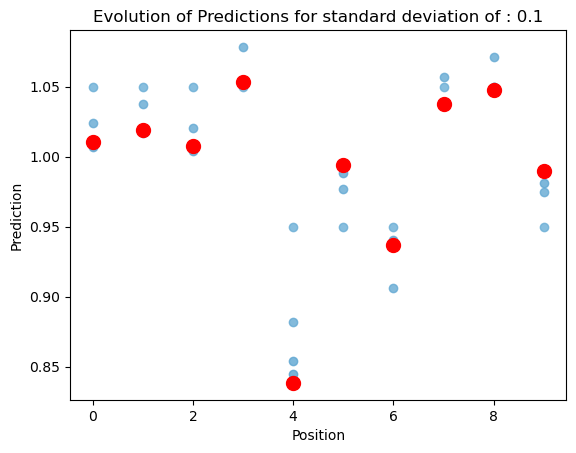

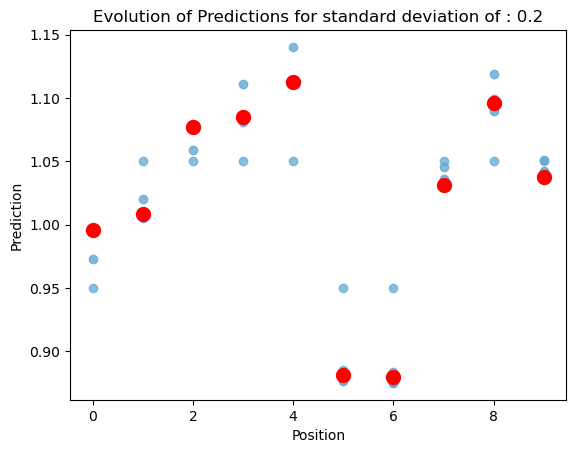

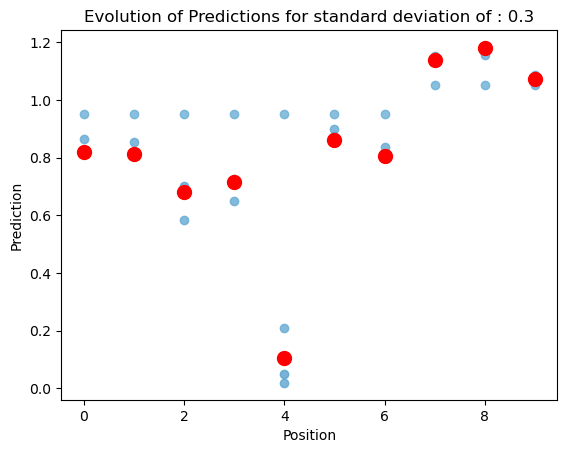

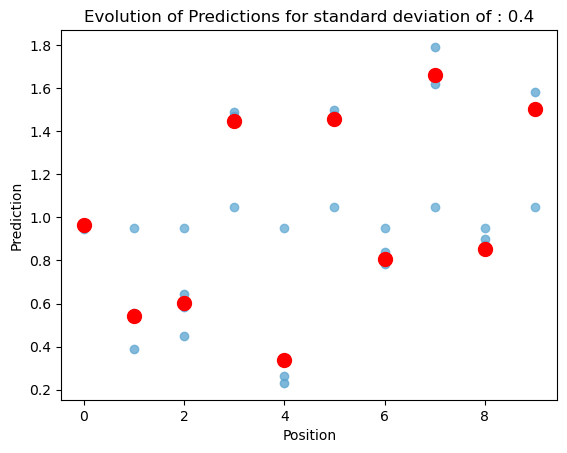

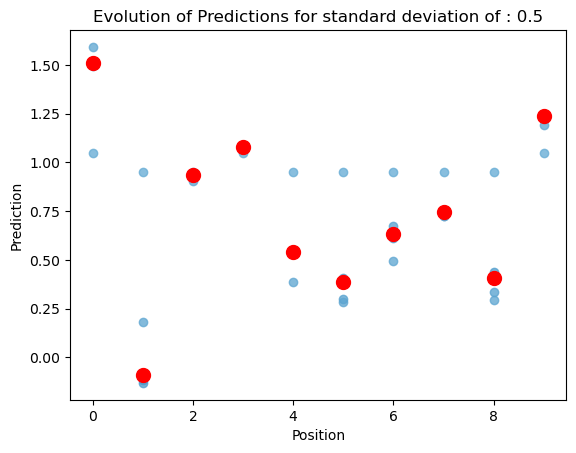

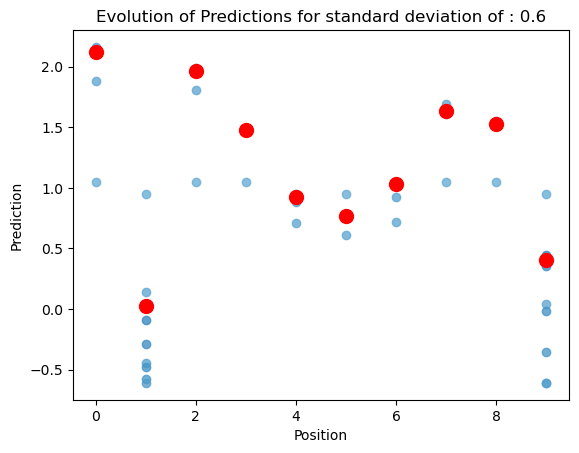

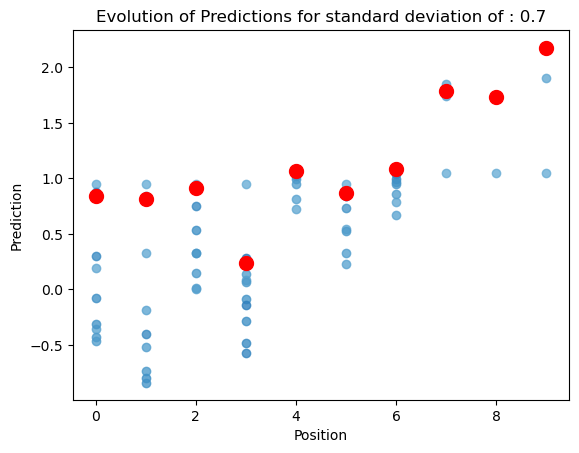

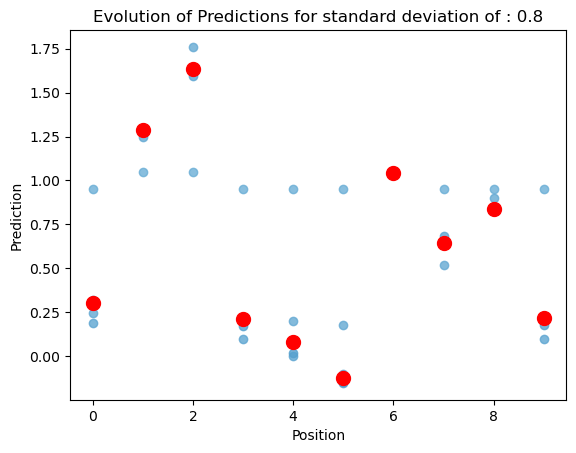

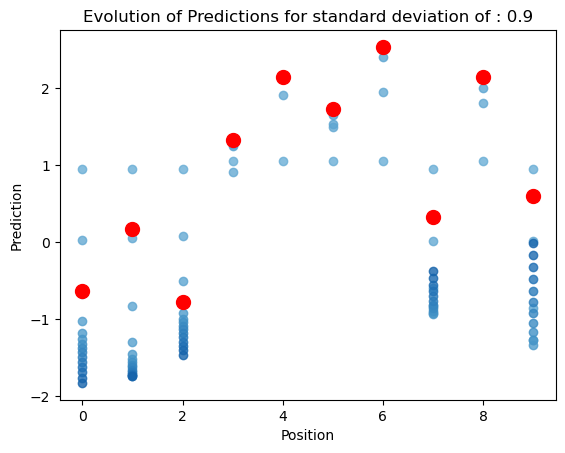

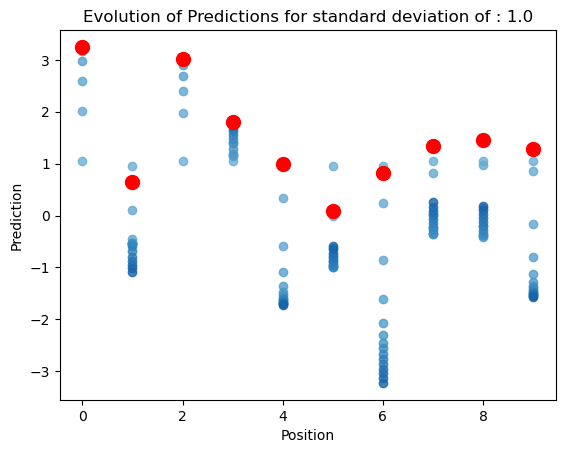

In [29]:
for stddev in stddevs:
    stddev=str(stddev)
    pred_array = data[stddev]['A_true']
    pred_list = data[stddev]['y_pred']

    # Generate the color gradient for pred_list
    colors = plt.cm.Blues(np.linspace(0.5, 0.8, len(pred_list)))

    # Plot each prediction array
    for i, prediction in enumerate(pred_list):
        plt.scatter(range(len(prediction)), prediction, color=colors[i], alpha=0.8)

    # Plot each float in pred_array
    plt.scatter(range(len(pred_array)), pred_array, color='red', s=100)

    # Set axis labels and title
    plt.xlabel('Position')
    plt.ylabel('Prediction')
    plt.title('Evolution of Predictions for standard deviation of : ' + str(stddev))

    # Show the plot
    plt.show()

## Graph of losses

### Error loss

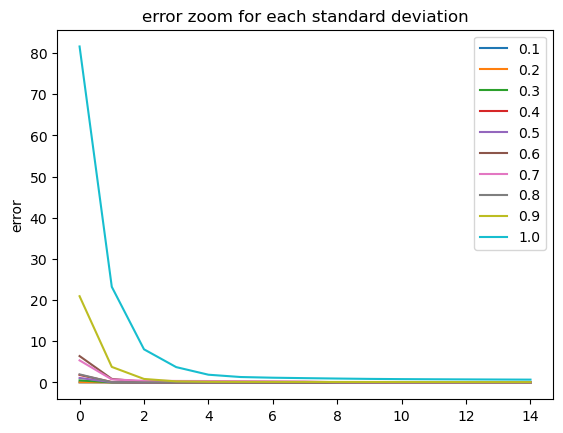

In [46]:
for stddev in stddevs:
    key=str(stddev)
    plt.plot(data[key]['training_loss'], label=key)

plt.title('error zoom for each standard deviation')
plt.ylabel('error')

plt.legend()
plt.show()

<b>Zooming</b>

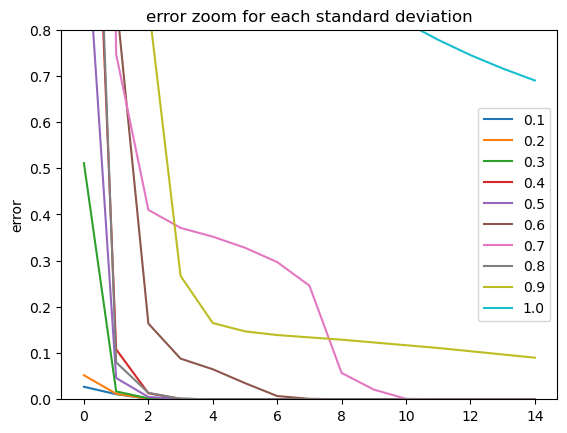

In [45]:
for stddev in stddevs:
    key=str(stddev)
    plt.plot(data[key]['training_loss'], label=key)

plt.title('error zoom for each standard deviation')
plt.ylabel('error')

plt.ylim(0,1)
plt.legend()
plt.show()

### Frobenius loss

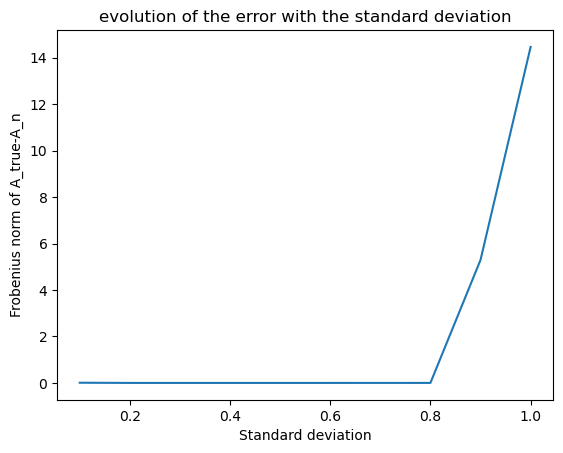

In [37]:
keys = stddevs
values = [data[str(stddev)]['frob'] for stddev in stddevs]

plt.plot(keys, values)
plt.title("evolution of the error with the standard deviation")
plt.xlabel('Standard deviation')
plt.ylabel('Frobenius norm of A_true-A_n')
plt.show()